# Выполнила: Скрипникова София, НПМ-01-22

## 1. Квадратичное программирование и QP-солвер

### 1. Установите QP-солвер, разберитесь с его интерфейсом.

In [1]:
pip install cvxopt

Note: you may need to restart the kernel to use updated packages.


### 2. Протестируйте солвер, решив простую задачу оптимизации в двумерном пространстве:
$$f(\boldsymbol x) = -8x_1 - 16x_2 + x_1^2 + 4x_2^2, \quad \text{s.t.:} \; x_1 + x_2 \leq 5, \; 0 \leq x_1 \leq 3, \; x_2 \geq 0$$

In [2]:
%pylab inline #хоть и сказано поменьше кода, но график красивый:)

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


C:\Users\gfdsa\AppData\Local\Temp\ipykernel_16704\2390794766.py:16: UserWarning: linewidths is ignored by contourf
  contourf(x1, x2, constr1 & constr2 & constr3, 1, alpha=0.5, linewidths=4, cmap='gray')


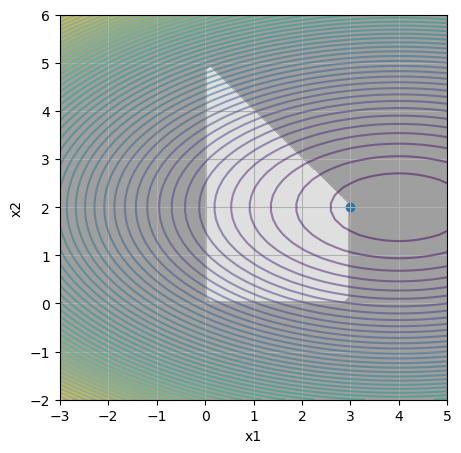

In [3]:
x1 = linspace(-3, 5, 50)
x2 = linspace(-2, 6, 50)
xx1, xx2 = meshgrid(x1, x2)

f = -8*xx1 - 16*xx2 + xx1**2 + 4*xx2**2
constr1 = (xx1 + xx2 <= 5)
constr2 = (0 <= xx1) & (xx1 <= 3)
constr3 = (xx2 >= 0)

figure(figsize=(5, 5))
grid(True)
xlabel('x1')
ylabel('x2')

contour(x1, x2, f, 50, alpha=0.5)
contourf(x1, x2, constr1 & constr2 & constr3, 1, alpha=0.5, linewidths=4, cmap='gray')
_ = scatter([3], [2])

In [1]:
from cvxopt import solvers
from cvxopt import matrix
import numpy as np

# Define QP parameters (directly)
P = matrix([2.0, 0.0, 0.0, 8.0], (2,2) )
q = matrix([-8.0,-16.0], (2,1))
G = matrix([1.0,-1.0,1.0,0.0,1.0,0.0,0.0,-1.0], (4,2))
h = matrix([5.0,0.0,3.0,0.0], (4,1))

# Construct the QP, invoke solver
sol = solvers.qp(P,q,G,h)

# Extract optimal value and solution
print(sol['x'])
print(sol['primal objective']) 

     pcost       dcost       gap    pres   dres
 0: -3.0512e+01 -3.8829e+01  8e+00  0e+00  2e-01
 1: -3.0792e+01 -3.1146e+01  4e-01  2e-16  5e-03
 2: -3.0982e+01 -3.1024e+01  4e-02  1e-16  4e-04
 3: -3.0997e+01 -3.1003e+01  6e-03  2e-16  5e-17
 4: -3.1000e+01 -3.1000e+01  7e-04  2e-16  3e-17
 5: -3.1000e+01 -3.1000e+01  1e-04  2e-16  4e-17
 6: -3.1000e+01 -3.1000e+01  1e-05  2e-16  3e-17
Optimal solution found.
[ 3.00e+00]
[ 2.00e+00]

-30.99999280553902


#### Ураааа, мы получили верное реешние!!!!

### 3. Какие из ограничений-неравенств задачи являются _активными_, т.е. влияют на точку оптимума, а какие ограничения можно выбросить и точка оптимума не поменяется?

Я считаю, что можно выбросить такие ограничения, как х2>=0 и х1>=0 и решение бы не поменялось, а вот x1+x2<=5 и x1<=3 являются активными ограничениями, от них решение зависит

## 2. Линейный SVM

### 1. Сведите задачу обучения линейного SVM к QP, реализуйте процедуру обучения Линейного SVM при помощи QP-солвера.

In [116]:
import numpy as np
from cvxopt import matrix, solvers
from sklearn.base import BaseEstimator

class LinearSVM(BaseEstimator):
    def __init__(self, C=C, transform=None):
        self.C = C
        self.transform = transform
        self.w = None
        self.b = None
        
    def fit(self, X, y):
        n_samples, n_features = X.shape
    
        
        P = matrix(np.block([[np.eye(n_features), np.zeros((n_features, n_samples + 1))],
                             [np.zeros((n_samples + 1, n_features + n_samples + 1))]]))
        q = matrix(np.hstack([np.zeros(n_features + 1), self.C * np.ones(n_samples)]))
  
        G_std = np.hstack([-np.diag(y).dot(X), -y[:, np.newaxis], -np.eye(n_samples)])
        G_slack = np.hstack([np.zeros((n_samples, n_features + 1)), -np.eye(n_samples)])
        G = matrix(np.vstack([G_std, G_slack]))
     
        h = matrix(np.hstack([-np.ones(n_samples), np.zeros(n_samples)]))
     
        A = matrix(np.hstack([np.zeros((1, n_features + 1)), np.ones((1, n_samples))]))
        b = matrix(np.zeros(1))
        
       
        P, q, G, h, A, b = [matrix(m, tc='d') for m in (P, q, G, h, A, b)]
        sol = solvers.qp(P, q, G, h, A, b)
        
         
        sol_vars = np.array(sol['x']).flatten() # создаем одномерный массив (копию) из входного многомерного массива
        self.weights_ = sol_vars[:n_features]
        self.bias_ = sol_vars[n_features]
    def predict(self, X):
        return (np.dot(X, self.weights_) + self.bias_).flatten()

    def predict_proba(self, X):
        return np.sign(self.predict_proba(X))


### 2. Сгенерируйте три случайные двумерные выборки для бинарной классификации:София Дмитриевна Скрипникова - с линейно-разделимыми классами - с хорошо разделимыми классами, но не линейно - с плохо разделимыми классами по имеющимся признакам

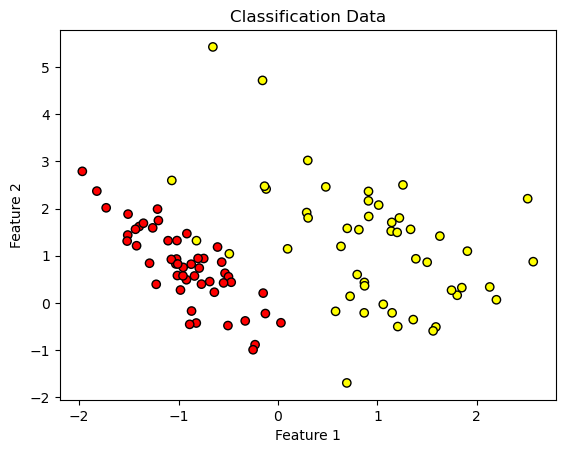

In [117]:
import matplotlib.pyplot as plt

X, y = make_classification(n_samples=100, n_features=2, n_redundant=0, n_clusters_per_class=1, random_state=2)

plt.scatter(X[:, 0], X[:, 1], c=y, cmap='autumn', edgecolor='black')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title('Classification Data')
plt.show()

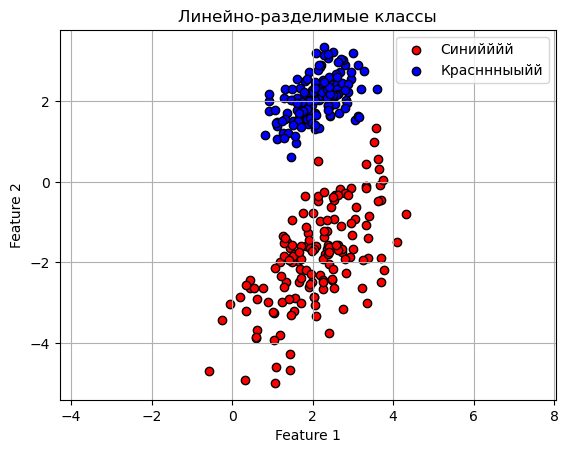

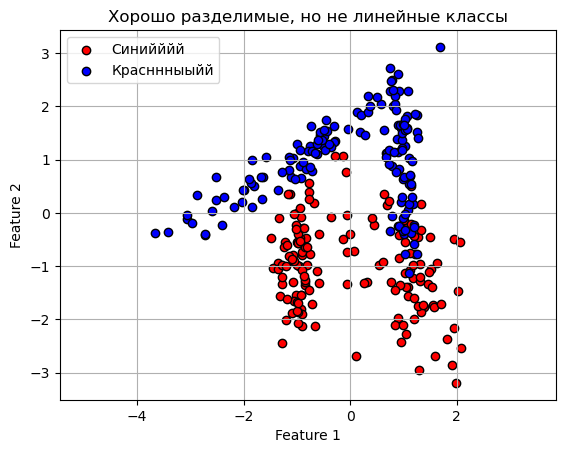

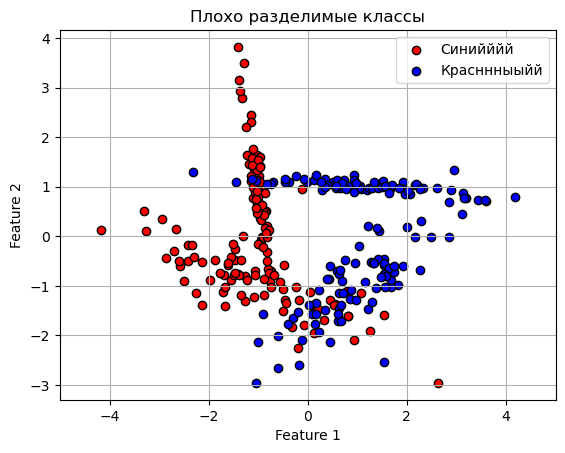

In [118]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification, make_moons, make_blobs

def datasets():
    # Линейно-разделимые классы
    X1, y1 = make_classification(n_samples=300, n_features=2, n_informative=2, n_redundant=0, 
                                 n_clusters_per_class=1, flip_y=0, class_sep=2.0, random_state=0)
    
    # Хорошо разделимые классы, но не линейно
    X2, y2 =  make_classification(n_samples=300, n_features=2, n_redundant=0, 
                                 n_clusters_per_class=2, random_state=4)
    
    # Плохо разделимые классы
    X3, y3 = make_classification(n_samples=300, n_features=2, n_redundant=0, 
                                 n_clusters_per_class=2, random_state=2)
    
    return (X1, y1), (X2, y2), (X3, y3)

def plot_samples(X, y, title):
    plt.scatter(X[y == 0][:, 0], X[y == 0][:, 1], color='red', label='Синийййй', edgecolor='k')
    plt.scatter(X[y == 1][:, 0], X[y == 1][:, 1], color='blue', label='Красннныыйй', edgecolor='k')
    plt.title(title)
    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')
    plt.legend()
    plt.axis('equal')
    plt.grid()
    plt.show()

# Генерация данных
(X1_linear, y1_linear), (X2_nonlinear, y2_nonlinear), (X3_poorly, y3_poorly) = datasets()


plot_samples(X1_linear, y1_linear, 'Линейно-разделимые классы')
plot_samples(X2_nonlinear, y2_nonlinear, 'Хорошо разделимые, но не линейные классы')
plot_samples(X3_poorly, y3_poorly, 'Плохо разделимые классы')


### 3.Протестируйте линейный SVM на сгенерированных выборках. Покажите на плоскости разделяющую прямую и линии уровня, ограничивающие коридор  𝑓(𝒙)=±1. Выделите опорные вектора точками другой формы или большего размера. Постройте классификаторы с различным значением параметра  𝐶


     pcost       dcost       gap    pres   dres
 0:  1.6719e-01  5.1452e+01  2e+03  2e+00  5e+02
 1:  9.9752e-01 -1.1621e+02  4e+02  6e-01  1e+02
 2:  1.5876e+00 -3.6370e+01  1e+02  2e-01  4e+01
 3:  1.7946e+00 -1.6234e+01  5e+01  8e-02  2e+01
 4:  2.0949e+00 -5.7505e+00  3e+01  4e-02  1e+01
 5:  2.2894e+00 -4.1686e+00  3e+01  4e-02  9e+00
 6:  3.2424e+00 -1.9024e+00  3e+01  3e-02  7e+00
 7:  3.5566e+00 -2.6122e+00  3e+01  3e-02  6e+00
 8:  3.6703e+00 -1.5670e+00  3e+01  2e-02  6e+00
 9:  4.1036e+00 -6.7088e-01  3e+01  2e-02  5e+00
10:  6.2122e+00  1.2815e+00  3e+01  2e-02  4e+00
11:  1.0574e+01  4.9993e+00  1e+01  6e-03  1e+00
12:  1.0548e+01  5.2412e+00  1e+01  5e-03  1e+00
13:  1.0823e+01  6.3482e+00  1e+01  4e-03  9e-01
14:  1.0931e+01  9.4483e+00  4e+00  1e-03  3e-01
15:  1.0947e+01  1.0557e+01  2e+00  5e-04  1e-01
16:  1.1391e+01  1.0596e+01  1e+00  3e-04  7e-02
17:  1.1370e+01  1.0692e+01  1e+00  2e-04  5e-02
18:  1.1391e+01  1.1374e+01  3e-02  6e-06  1e-03
19:  1.1394e+01  1.13

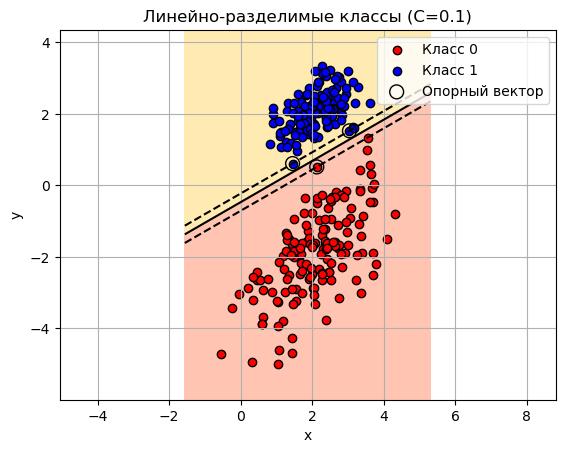

     pcost       dcost       gap    pres   dres
 0:  1.6719e-01  5.1452e+01  2e+03  2e+00  5e+01
 1:  9.9752e-01 -1.1621e+02  4e+02  6e-01  1e+01
 2:  1.5876e+00 -3.6370e+01  1e+02  2e-01  4e+00
 3:  1.7946e+00 -1.6234e+01  5e+01  8e-02  2e+00
 4:  2.0949e+00 -5.7505e+00  3e+01  4e-02  1e+00
 5:  2.2894e+00 -4.1686e+00  3e+01  4e-02  9e-01
 6:  3.2424e+00 -1.9024e+00  3e+01  3e-02  7e-01
 7:  3.5566e+00 -2.6122e+00  3e+01  3e-02  6e-01
 8:  3.6703e+00 -1.5670e+00  3e+01  2e-02  6e-01
 9:  4.1036e+00 -6.7088e-01  3e+01  2e-02  5e-01
10:  6.2122e+00  1.2815e+00  3e+01  2e-02  4e-01
11:  1.0574e+01  4.9993e+00  1e+01  6e-03  1e-01
12:  1.0548e+01  5.2412e+00  1e+01  5e-03  1e-01
13:  1.0823e+01  6.3482e+00  1e+01  4e-03  9e-02
14:  1.0931e+01  9.4483e+00  4e+00  1e-03  3e-02
15:  1.0947e+01  1.0557e+01  2e+00  5e-04  1e-02
16:  1.1391e+01  1.0596e+01  1e+00  3e-04  7e-03
17:  1.1370e+01  1.0692e+01  1e+00  2e-04  5e-03
18:  1.1391e+01  1.1374e+01  3e-02  6e-06  1e-04
19:  1.1394e+01  1.13

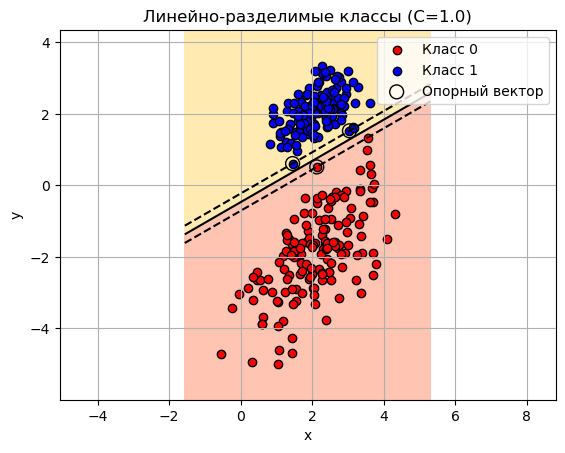

     pcost       dcost       gap    pres   dres
 0:  1.6719e-01  5.1452e+01  2e+03  2e+00  5e+00
 1:  9.9752e-01 -1.1621e+02  4e+02  6e-01  1e+00
 2:  1.5876e+00 -3.6370e+01  1e+02  2e-01  4e-01
 3:  1.7946e+00 -1.6234e+01  5e+01  8e-02  2e-01
 4:  2.0949e+00 -5.7505e+00  3e+01  4e-02  1e-01
 5:  2.2894e+00 -4.1686e+00  3e+01  4e-02  9e-02
 6:  3.2424e+00 -1.9024e+00  3e+01  3e-02  7e-02
 7:  3.5566e+00 -2.6122e+00  3e+01  3e-02  6e-02
 8:  3.6703e+00 -1.5670e+00  3e+01  2e-02  6e-02
 9:  4.1036e+00 -6.7088e-01  3e+01  2e-02  5e-02
10:  6.2122e+00  1.2815e+00  3e+01  2e-02  4e-02
11:  1.0574e+01  4.9993e+00  1e+01  6e-03  1e-02
12:  1.0548e+01  5.2412e+00  1e+01  5e-03  1e-02
13:  1.0823e+01  6.3482e+00  1e+01  4e-03  9e-03
14:  1.0931e+01  9.4483e+00  4e+00  1e-03  3e-03
15:  1.0947e+01  1.0557e+01  2e+00  5e-04  1e-03
16:  1.1391e+01  1.0596e+01  1e+00  3e-04  7e-04
17:  1.1370e+01  1.0692e+01  1e+00  2e-04  5e-04
18:  1.1391e+01  1.1374e+01  3e-02  6e-06  1e-05
19:  1.1394e+01  1.13

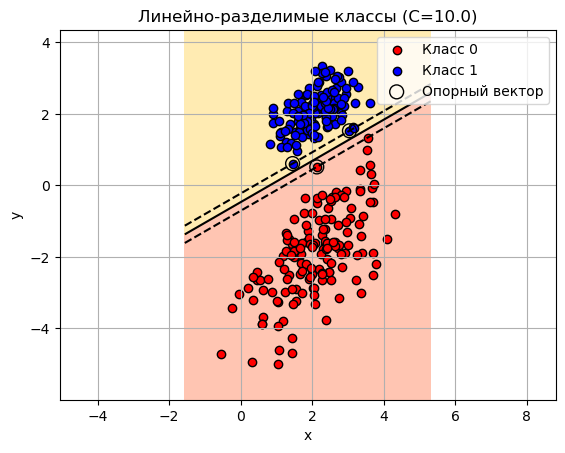

     pcost       dcost       gap    pres   dres
 0:  3.0268e-01  1.3035e+02  2e+03  3e+00  3e+02
 1:  2.4944e+00 -2.0349e+01  5e+02  9e-01  8e+01
 2:  2.4437e+00  1.6817e+02  2e+02  4e-01  4e+01
 3:  2.1093e+00  4.9783e+02  2e+02  4e-01  4e+01
 4:  1.9882e+00  8.7974e+02  3e+02  4e-01  4e+01
 5:  1.6441e+00  2.1349e+03  5e+02  4e-01  4e+01
 6:  1.5286e+00  4.7826e+03  7e+02  4e-01  3e+01
 7:  1.6654e+00  1.2782e+04  1e+03  4e-01  3e+01
 8:  1.4039e+00  1.3210e+04  2e+03  4e-01  3e+01
 9:  1.4563e+00  2.6031e+04  3e+03  4e-01  3e+01
10:  1.4866e+00  1.0385e+05  7e+03  3e-01  3e+01
11:  1.4733e+00  1.4237e+06  2e+04  3e-01  3e+01
12:  1.4483e+00  4.5720e+07  3e+05  3e-01  3e+01
13:  1.4112e+00  3.1191e+08  2e+06  3e-01  3e+01
14:  1.4176e+00  3.7057e+10  4e+07  3e-01  3e+01
15:  1.4356e+00  1.8530e+13  9e+09  3e-01  3e+01
16:  1.4360e+00  3.5064e+16  1e+12  3e-01  3e+01
17:  1.4454e+00  8.3821e+20  2e+15  3e-01  2e+07
18:  1.4706e+00  4.0360e+22  1e+17  3e-01  6e+14
19:  1.4144e+00  1.30

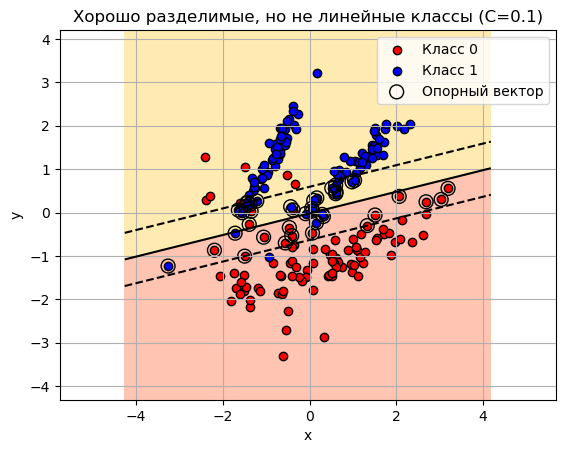

     pcost       dcost       gap    pres   dres
 0:  3.0268e-01  1.3035e+02  2e+03  3e+00  3e+01
 1:  2.4944e+00 -2.0349e+01  5e+02  9e-01  8e+00
 2:  2.4437e+00  1.6817e+02  2e+02  4e-01  4e+00
 3:  2.1093e+00  4.9783e+02  2e+02  4e-01  4e+00
 4:  1.9882e+00  8.7974e+02  3e+02  4e-01  4e+00
 5:  1.6441e+00  2.1349e+03  5e+02  4e-01  4e+00
 6:  1.5286e+00  4.7826e+03  7e+02  4e-01  3e+00
 7:  1.6654e+00  1.2782e+04  1e+03  4e-01  3e+00
 8:  1.4039e+00  1.3210e+04  2e+03  4e-01  3e+00
 9:  1.4563e+00  2.6031e+04  3e+03  4e-01  3e+00
10:  1.4866e+00  1.0385e+05  7e+03  3e-01  3e+00
11:  1.4733e+00  1.4237e+06  2e+04  3e-01  3e+00
12:  1.4483e+00  4.5720e+07  3e+05  3e-01  3e+00
13:  1.4112e+00  3.1191e+08  2e+06  3e-01  3e+00
14:  1.4176e+00  3.7057e+10  4e+07  3e-01  3e+00
15:  1.4356e+00  1.8530e+13  9e+09  3e-01  3e+00
16:  1.4360e+00  3.5064e+16  1e+12  3e-01  4e+00
17:  1.4140e+00  4.5074e+20  9e+15  3e-01  7e+06
18:  1.4138e+00  2.0912e+25  4e+19  3e-01  2e+09
19:  1.4138e+00  1.08

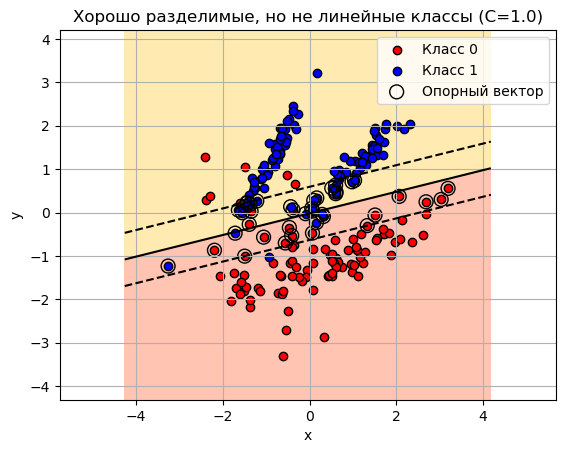

     pcost       dcost       gap    pres   dres
 0:  3.0268e-01  1.3035e+02  2e+03  3e+00  3e+00
 1:  2.4944e+00 -2.0349e+01  5e+02  9e-01  8e-01
 2:  2.4437e+00  1.6817e+02  2e+02  4e-01  4e-01
 3:  2.1093e+00  4.9783e+02  2e+02  4e-01  4e-01
 4:  1.9882e+00  8.7974e+02  3e+02  4e-01  4e-01
 5:  1.6441e+00  2.1349e+03  5e+02  4e-01  4e-01
 6:  1.5286e+00  4.7826e+03  7e+02  4e-01  3e-01
 7:  1.6654e+00  1.2782e+04  1e+03  4e-01  3e-01
 8:  1.4039e+00  1.3210e+04  2e+03  4e-01  3e-01
 9:  1.4563e+00  2.6031e+04  3e+03  4e-01  3e-01
10:  1.4866e+00  1.0385e+05  7e+03  3e-01  3e-01
11:  1.4733e+00  1.4237e+06  2e+04  3e-01  3e-01
12:  1.4483e+00  4.5720e+07  3e+05  3e-01  3e-01
13:  1.4112e+00  3.1191e+08  2e+06  3e-01  3e-01
14:  1.4176e+00  3.7057e+10  4e+07  3e-01  3e-01
15:  1.4356e+00  1.8530e+13  9e+09  3e-01  3e-01
16:  1.4360e+00  3.5064e+16  1e+12  3e-01  4e-01
17:  1.4504e+00  8.4160e+20  2e+15  3e-01  4e+05
18:  1.4142e+00  1.8214e+24  4e+18  3e-01  1e+12
19:  1.4138e+00  1.03

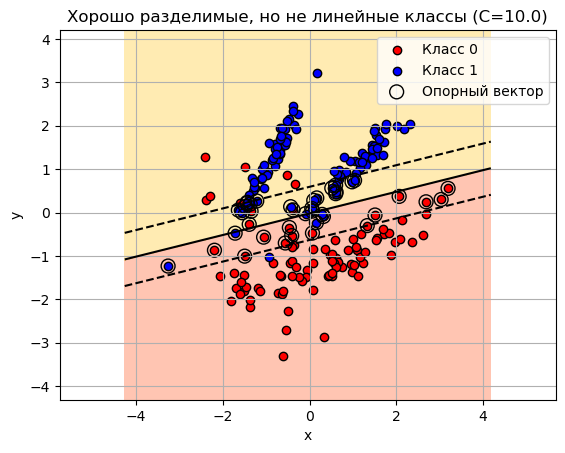

     pcost       dcost       gap    pres   dres
 0:  2.6821e-01  1.0554e+02  1e+03  3e+00  3e+02
 1:  2.0903e+00 -5.3965e+01  5e+02  9e-01  9e+01
 2:  3.1162e+00  3.5835e+01  2e+02  4e-01  4e+01
 3:  2.9151e+00  2.4559e+02  1e+02  2e-01  2e+01
 4:  2.2518e+00  1.0968e+03  2e+02  2e-01  2e+01
 5:  2.0213e+00  3.4931e+03  4e+02  2e-01  2e+01
 6:  2.0485e+00  1.2220e+04  9e+02  2e-01  2e+01
 7:  2.0847e+00  6.7404e+04  3e+03  2e-01  2e+01
 8:  2.0543e+00  1.2029e+06  1e+04  2e-01  2e+01
 9:  2.0924e+00  4.1406e+07  3e+05  2e-01  2e+01
10:  2.1043e+00  3.8653e+09  1e+07  2e-01  2e+01
11:  2.1254e+00  8.6231e+11  1e+09  2e-01  2e+01
12:  2.1319e+00  4.0964e+14  2e+11  2e-01  2e+01
13:  2.1152e+00  2.0128e+17  8e+13  2e-01  6e+01
14:  2.0992e+00  7.8637e+19  3e+16  2e-01  4e+05
15:  2.0724e+00  2.6871e+22  8e+18  2e-01  2e+09
16:  2.0109e+00  6.5405e+24  2e+21  2e-01  1e+14
17:  2.0103e+00  2.4564e+25  7e+21  2e-01  5e+14
18:  2.0638e+00  2.3577e+25  7e+21  2e-01  1e+17
19:  2.0321e+00  1.20

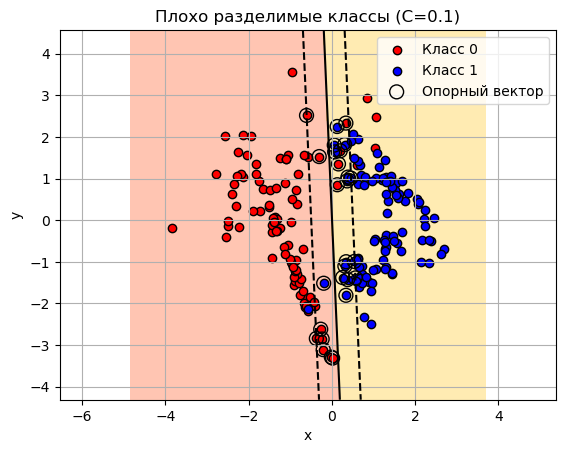

     pcost       dcost       gap    pres   dres
 0:  2.6821e-01  1.0554e+02  1e+03  3e+00  3e+01
 1:  2.0903e+00 -5.3965e+01  5e+02  9e-01  9e+00
 2:  3.1162e+00  3.5835e+01  2e+02  4e-01  4e+00
 3:  2.9151e+00  2.4559e+02  1e+02  2e-01  2e+00
 4:  2.2518e+00  1.0968e+03  2e+02  2e-01  2e+00
 5:  2.0213e+00  3.4931e+03  4e+02  2e-01  2e+00
 6:  2.0485e+00  1.2220e+04  9e+02  2e-01  2e+00
 7:  2.0847e+00  6.7404e+04  3e+03  2e-01  2e+00
 8:  2.0543e+00  1.2029e+06  1e+04  2e-01  2e+00
 9:  2.0924e+00  4.1406e+07  3e+05  2e-01  2e+00
10:  2.1043e+00  3.8653e+09  1e+07  2e-01  2e+00
11:  2.1254e+00  8.6231e+11  1e+09  2e-01  2e+00
12:  2.1319e+00  4.0964e+14  2e+11  2e-01  2e+00
13:  2.1152e+00  2.0128e+17  8e+13  2e-01  7e+00
14:  2.0992e+00  7.8637e+19  3e+16  2e-01  4e+04
15:  2.0724e+00  2.6871e+22  8e+18  2e-01  3e+08
16:  2.0109e+00  6.5364e+24  2e+21  2e-01  1e+13
17:  2.0103e+00  2.4686e+25  7e+21  2e-01  8e+13
18:  2.0638e+00  2.3691e+25  7e+21  2e-01  2e+16
19:  2.0321e+00  1.21

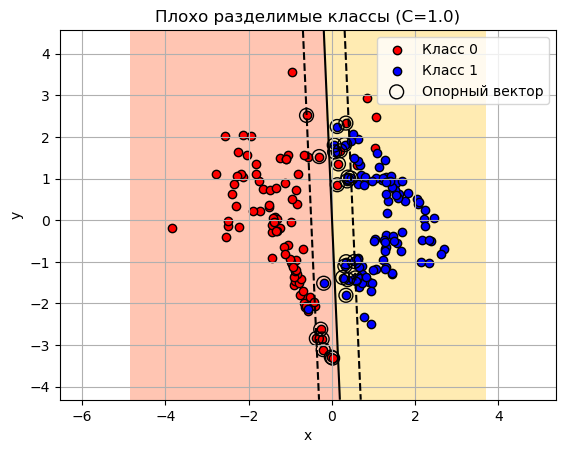

     pcost       dcost       gap    pres   dres
 0:  2.6821e-01  1.0554e+02  1e+03  3e+00  3e+00
 1:  2.0903e+00 -5.3965e+01  5e+02  9e-01  9e-01
 2:  3.1162e+00  3.5835e+01  2e+02  4e-01  4e-01
 3:  2.9151e+00  2.4559e+02  1e+02  2e-01  2e-01
 4:  2.2518e+00  1.0968e+03  2e+02  2e-01  2e-01
 5:  2.0213e+00  3.4931e+03  4e+02  2e-01  2e-01
 6:  2.0485e+00  1.2220e+04  9e+02  2e-01  2e-01
 7:  2.0847e+00  6.7404e+04  3e+03  2e-01  2e-01
 8:  2.0543e+00  1.2029e+06  1e+04  2e-01  2e-01
 9:  2.0924e+00  4.1406e+07  3e+05  2e-01  2e-01
10:  2.1043e+00  3.8653e+09  1e+07  2e-01  2e-01
11:  2.1254e+00  8.6231e+11  1e+09  2e-01  2e-01
12:  2.1319e+00  4.0964e+14  2e+11  2e-01  2e-01
13:  2.1152e+00  2.0128e+17  8e+13  2e-01  6e-01
14:  2.0992e+00  7.8637e+19  3e+16  2e-01  6e+03
15:  2.0724e+00  2.6871e+22  8e+18  2e-01  1e+07
16:  2.0109e+00  6.5447e+24  2e+21  2e-01  4e+11
17:  2.0103e+00  2.4650e+25  7e+21  2e-01  7e+12
18:  2.0638e+00  2.3659e+25  7e+21  2e-01  2e+15
19:  2.0321e+00  1.21

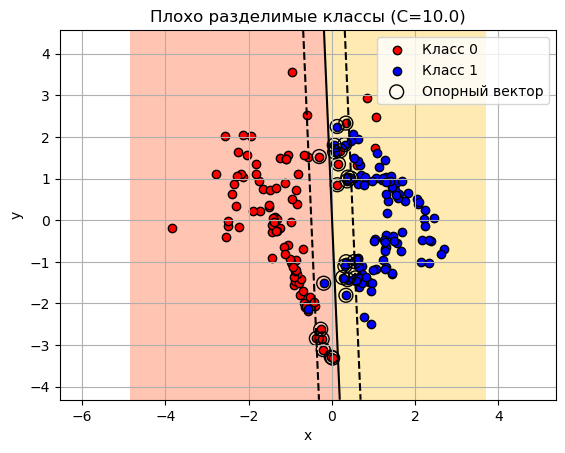

In [131]:
def linear_separation(X, y, clf, title):
    h = 0.02  # шаг сетки
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    
    Z = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    
    plt.contourf(xx, yy, Z > 0, alpha=0.3, cmap='autumn', levels=[-1, 0, 1])
    plt.contour(xx, yy, Z, colors='k', linestyles=['--', '-', '--'], levels=[-1, 0, 1])
    
    plt.scatter(X[y == 0][:, 0], X[y == 0][:, 1], color='red', label='Класс 0', edgecolor='k')
    plt.scatter(X[y == 1][:, 0], X[y == 1][:, 1], color='blue', label='Класс 1', edgecolor='k')
    
    support_vector_indices = np.where((np.abs(clf.predict_proba(X)) <= 1 + 1e-2))[0]
    plt.scatter(X[support_vector_indices][:, 0], X[support_vector_indices][:, 1], s=100, facecolors='none', edgecolor='k', label='Опорный вектор')

    plt.title(title)
    plt.xlabel('х')
    plt.ylabel('у')
    plt.legend()
    plt.axis('equal')
    plt.grid()
    plt.show()

(X1_linear, y1_linear), (X2_nonlinear, y2_nonlinear), (X3_poorly, y3_poorly) = datasets()


for X, y, dataset_name in [(X1_linear, y1_linear, 'Линейно-разделимые классы'), 
                            (X2_nonlinear, y2_nonlinear, 'Хорошо разделимые, но не линейные классы'),
                            (X3_poorly, y3_poorly, 'Плохо разделимые классы')]:
    for C in [0.1, 1.0, 10.0]:
        clf = LinearSVM(C=C)
        clf.fit(X, y)
        linear_separation(X, y, clf, f'{dataset_name} (C={C})')

### 4.Как зависит число опорных векторов от параметра  𝐶 для различных выборок?

Количество увеличивается, т.к увеличивается количество ненулевых решений(появляется больше данных)

### 5.Используя явное преобразование признаков обучите методом опорных векторов квадратичную разделяющую поверхность. Покажите ее на плоскости.

     pcost       dcost       gap    pres   dres
 0:  3.3763e-01  2.8914e+01  5e+02  2e+00  2e+01
 1:  1.9875e+00 -2.4698e+01  1e+02  6e-01  5e+00
 2:  3.2251e+00 -4.8250e+00  5e+01  2e-01  2e+00
 3:  4.3317e+00  1.1108e+00  4e+01  2e-01  1e+00
 4:  5.4890e+00  1.0133e+01  3e+01  1e-01  8e-01
 5:  6.6335e+00  1.3854e+01  3e+01  9e-02  7e-01
 6:  7.9403e+00  2.2999e+01  3e+01  8e-02  6e-01
 7:  8.4818e+00  3.9699e+01  3e+01  7e-02  5e-01
 8:  1.2139e+01  6.3168e+01  4e+01  6e-02  5e-01
 9:  1.2531e+01  6.6397e+01  4e+01  6e-02  5e-01
10:  2.0730e+01  9.1426e+01  5e+01  5e-02  4e-01
11:  2.8733e+01  9.8763e+01  6e+01  5e-02  4e-01
12:  2.8532e+01  1.0488e+02  6e+01  5e-02  4e-01
13:  3.6588e+01  1.1052e+02  6e+01  4e-02  3e-01
14:  3.6460e+01  1.2532e+02  7e+01  4e-02  3e-01
15:  4.5459e+01  1.6068e+02  8e+01  4e-02  3e-01
16:  4.9007e+01  3.1661e+02  9e+01  3e-02  3e-01
17:  7.7435e+01  4.7054e+02  1e+02  3e-02  2e-01
18:  7.7217e+01  4.9580e+02  1e+02  3e-02  2e-01
19:  1.6083e+02  5.58

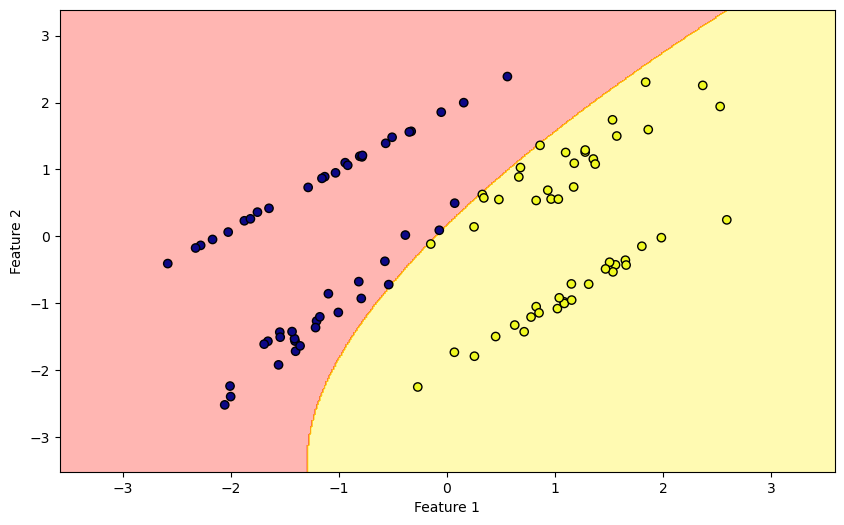

In [128]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import PolynomialFeatures
from sklearn.datasets import make_classification
import cvxopt
from cvxopt import matrix, solvers
from sklearn.base import BaseEstimator

class LinearSVM(BaseEstimator):
    def __init__(self, C=1.0, transform=None):
        self.C = C
        self.transform = transform
        self.weights_ = None
        self.bias_ = None
    
    def fit(self, X, y):
        if self.transform:
            X = self.transform(X)
            
        n_samples, n_features = X.shape
        y = np.where(y <= 0, -1, 1)
        
        K = np.dot(X, X.T)
        P = matrix(np.block([[np.eye(n_features), np.zeros((n_features, n_samples + 1))],
                             [np.zeros((n_samples + 1, n_features + n_samples + 1))]]))
        q = matrix(np.hstack([np.zeros(n_features + 1), self.C * np.ones(n_samples)]))
        
        G_std = np.hstack([-np.diag(y).dot(X), -y[:, np.newaxis], -np.eye(n_samples)])
        G_slack = np.hstack([np.zeros((n_samples, n_features + 1)), -np.eye(n_samples)])
        G = matrix(np.vstack([G_std, G_slack]))
        
        h = matrix(np.hstack([-np.ones(n_samples), np.zeros(n_samples)]))
        A = matrix(np.hstack([np.zeros((1, n_features + 1)), np.ones((1, n_samples))]))
        b = matrix(np.zeros(1))
        
        P, q, G, h, A, b = [matrix(m, tc='d') for m in (P, q, G, h, A, b)]
        sol = solvers.qp(P, q, G, h, A, b)
        
        sol_vars = np.array(sol['x']).flatten()
        self.weights_ = sol_vars[:n_features]
        self.bias_ = sol_vars[n_features]
    
    def predict_proba(self, X):
        return (np.dot(X, self.weights_) + self.bias_).flatten()
    
    def predict(self, X):
        return np.sign(self.predict_proba(X))

X, y = make_classification(n_samples=100, n_features=2, n_informative=2, n_redundant=0, random_state=42)

poly = PolynomialFeatures(degree=2)
X_poly = poly.fit_transform(X)

svm = LinearSVM(C=1.0, transform=poly.transform)
svm.fit(X, y)



xx, yy = np.meshgrid(np.linspace(X[:, 0].min() - 1, X[:, 0].max() + 1, 500),
                     np.linspace(X[:, 1].min() - 1, X[:, 1].max() + 1, 500))
X_grid = np.c_[xx.ravel(), yy.ravel()]
X_grid_poly = poly.transform(X_grid)
Z = svm.predict(X_grid_poly)
Z = Z.reshape(xx.shape)

plt.figure(figsize=(10, 6))
plt.contourf(xx, yy, Z, alpha=0.3, cmap='autumn')
plt.scatter(X[:, 0], X[:, 1], c=y, edgecolors='k', cmap='plasma')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.show()


### Задание 3

### 1.Реализуйте процедуру обучения ядрового SVM, используя QP-солвер.

In [9]:
from sklearn.datasets import make_classification

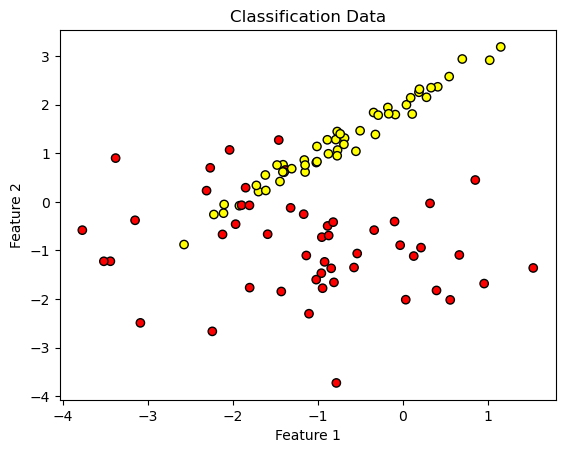

In [81]:
import matplotlib.pyplot as plt

X, y = make_classification(n_samples=100, n_features=2, n_redundant=0, n_clusters_per_class=1, random_state=4)
y = np.where((y==0), -1, 1)

plt.scatter(X[:, 0], X[:, 1], c=y, cmap='autumn', edgecolor='black')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title('Classification Data')
plt.show()

In [82]:
from cvxopt import solvers, matrix

In [84]:
class DualSVM:
    def __init__(self, C, kernel=None):
        self.C = C
        self.kernel = kernel
        if kernel is None:
            self.kernel = lambda x1, x2: np.dot(x1, x2.T)

        
    def fit(self, X, y):
        N, d = X.shape
        X_ex = np.zeros((X.shape[0], X.shape[1]+1))
        X_ex[:,:X.shape[1]] = X
        X_ex[:, -1] = 1
        P = cvxopt.matrix(np.outer(y, y) * self.kernel(X_ex, X_ex)) 
        q = cvxopt.matrix(-np.ones(N)) 
        G = cvxopt.matrix(np.vstack((-np.eye(N), np.eye(N))))  
        h = cvxopt.matrix(np.hstack((np.zeros(N), np.ones(N) * self.C)))  
        
        sol = cvxopt.solvers.qp(P, q, G, h) 
        lmbd = np.array(sol["x"]).reshape((N))
        almoust_w = np.sum(np.multiply((lmbd * y).reshape(N, 1), X_ex), axis=0)
        self.w = almoust_w[:N-1]
        self.b = almoust_w[-1]
        self.support_vecs = lmbd > 1e-6
        self.lmbd = lmbd
        self.X_ex = X_ex
        self.y = y
    
    def predict(self, X):
        return np.sign(self.predict_proba(X))
    
    def predict_proba(self, X):
        X_ex = np.zeros((X.shape[0], X.shape[1]+1))
        X_ex[:,:X.shape[1]] = X
        X_ex[:, -1] = 1
        return np.sum(np.diag(self.lmbd * self.y) @ self.kernel(self.X_ex, X_ex), axis=0)


### 2 Протестируйте на случайных двумерных выборках ядровой SVM. Покажите на плоскости строящиеся разделяющие поверхности, линии уровня, ограничивающие коридор  𝑓(𝒙)=±1

In [111]:
def paint(X, y, kernel=None):
    fig, axs = plt.subplots(2, 3, figsize=(18, 7))

    m = X.min()
    M = X.max()
    xvals = np.linspace(m - .2, M + .2, 100)
    yvals = np.linspace(m - .2, M + .2, 100)

    xx, yy = np.meshgrid(xvals, yvals)
    cs = np.logspace(-2, 4, 7)

    for k in range(6):
        svm = DualSVM(cs[k], kernel=kernel)
        s = svm.fit(X, y)
        pred_on_grid = svm.predict_proba(np.c_[xx.ravel(), yy.ravel()])

        zz = np.reshape(pred_on_grid, xx.shape)
        i = k // 3
        j = k % 3

        axs[i][j].pcolormesh(xx, yy, zz, cmap='autumn', zorder=0)
        axs[i][j].scatter(X[:, 0], X[:, 1], c=y, cmap='plasma')
        axs[i][j].scatter(X[svm.lmbd > 1e-6][:, 0], X[svm.lmbd > 1e-6][:, 1], 
            s=50, facecolors='none', edgecolors='k')


        axs[i][j].contour(xx, yy, zz, levels=(0,), colors='k', linewidths=1.5, zorder=1)
        axs[i][j].contour(xx, yy, zz, levels=(-1, 1), colors='k', linewidths=1, zorder=1, linestyles='dashed')
        axs[i][j].set_title(f'C={cs[k]}')

     pcost       dcost       gap    pres   dres
 0: -2.2657e+01 -2.1736e+00  6e+02  3e+01  4e-15
 1: -7.5106e-01 -2.1615e+00  9e+00  3e-01  4e-15
 2: -4.9224e-01 -1.5829e+00  1e+00  4e-17  6e-16
 3: -5.6307e-01 -6.9985e-01  1e-01  2e-17  5e-16
 4: -6.1803e-01 -6.4452e-01  3e-02  2e-17  5e-16
 5: -6.3028e-01 -6.3513e-01  5e-03  2e-17  4e-16
 6: -6.3270e-01 -6.3316e-01  5e-04  2e-17  4e-16
 7: -6.3295e-01 -6.3296e-01  6e-06  2e-17  5e-16
 8: -6.3295e-01 -6.3295e-01  6e-08  2e-17  4e-16
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -2.4662e+01 -2.0439e+01  6e+02  3e+01  5e-15
 1: -4.4022e+00 -1.9191e+01  4e+01  1e+00  4e-15
 2: -3.0942e+00 -9.5386e+00  7e+00  4e-02  1e-15
 3: -3.5810e+00 -4.5467e+00  1e+00  5e-03  9e-16
 4: -3.9318e+00 -4.1076e+00  2e-01  8e-04  8e-16
 5: -3.9887e+00 -4.0351e+00  5e-02  2e-04  9e-16
 6: -4.0072e+00 -4.0140e+00  7e-03  2e-05  1e-15
 7: -4.0103e+00 -4.0105e+00  2e-04  5e-07  1e-15
 8: -4.0104e+00 -4.0104e+00  2e-06  5e-09  8e-1

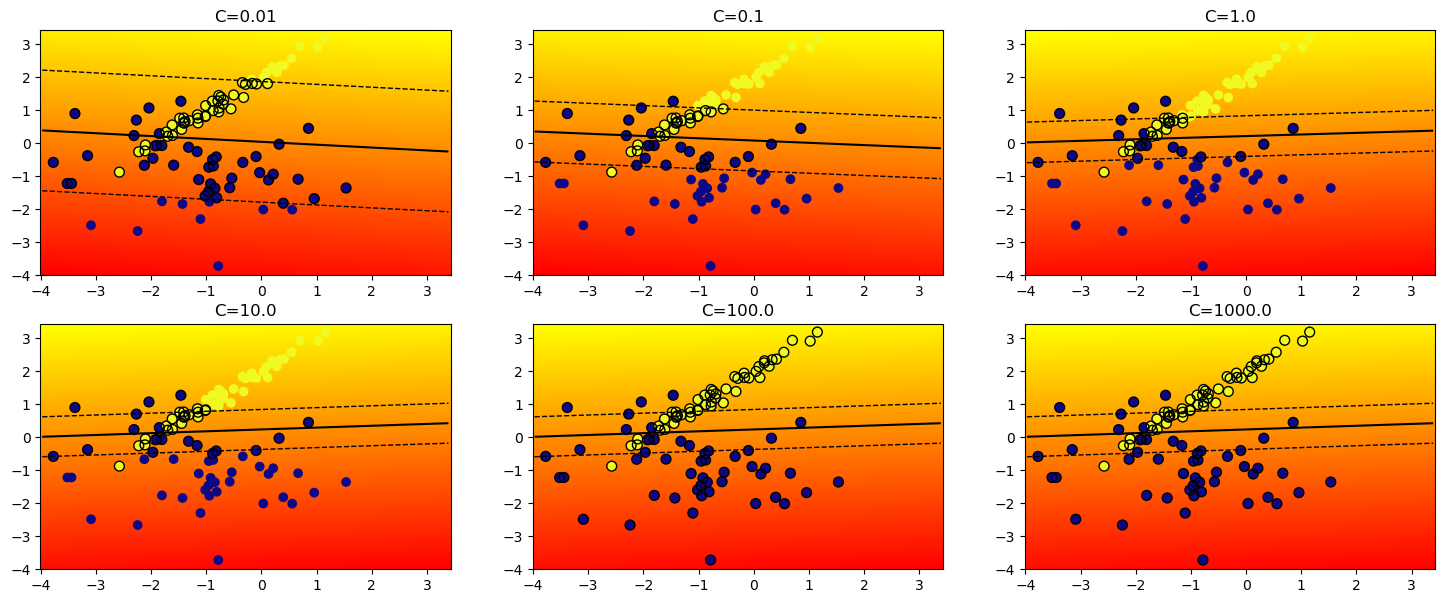

In [112]:
paint(X,y)

### 3 Как ведет себя SVM с полиномиальным ядром в зависимости от параметров  𝐶 и степени ядра  𝑝?

     pcost       dcost       gap    pres   dres
 0: -2.2653e+01 -2.1698e+00  6e+02  3e+01  5e-15
 1: -7.2324e-01 -2.1590e+00  8e+00  3e-01  4e-15
 2: -4.9254e-01 -1.5435e+00  1e+00  4e-17  6e-16
 3: -5.6444e-01 -6.9453e-01  1e-01  2e-17  5e-16
 4: -6.2064e-01 -6.4148e-01  2e-02  2e-17  5e-16
 5: -6.3067e-01 -6.3432e-01  4e-03  2e-17  5e-16
 6: -6.3262e-01 -6.3282e-01  2e-04  2e-17  5e-16
 7: -6.3272e-01 -6.3273e-01  5e-06  2e-17  5e-16
 8: -6.3273e-01 -6.3273e-01  2e-07  2e-17  5e-16
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -2.4657e+01 -2.0433e+01  6e+02  3e+01  5e-15
 1: -4.4153e+00 -1.9185e+01  4e+01  1e+00  5e-15
 2: -3.0884e+00 -9.6187e+00  7e+00  4e-02  2e-15
 3: -3.5744e+00 -4.5490e+00  1e+00  5e-03  1e-15
 4: -3.9305e+00 -4.1058e+00  2e-01  7e-04  1e-15
 5: -3.9884e+00 -4.0295e+00  4e-02  2e-04  8e-16
 6: -4.0042e+00 -4.0116e+00  8e-03  2e-05  9e-16
 7: -4.0075e+00 -4.0077e+00  2e-04  4e-07  1e-15
 8: -4.0076e+00 -4.0076e+00  5e-06  6e-09  1e-1

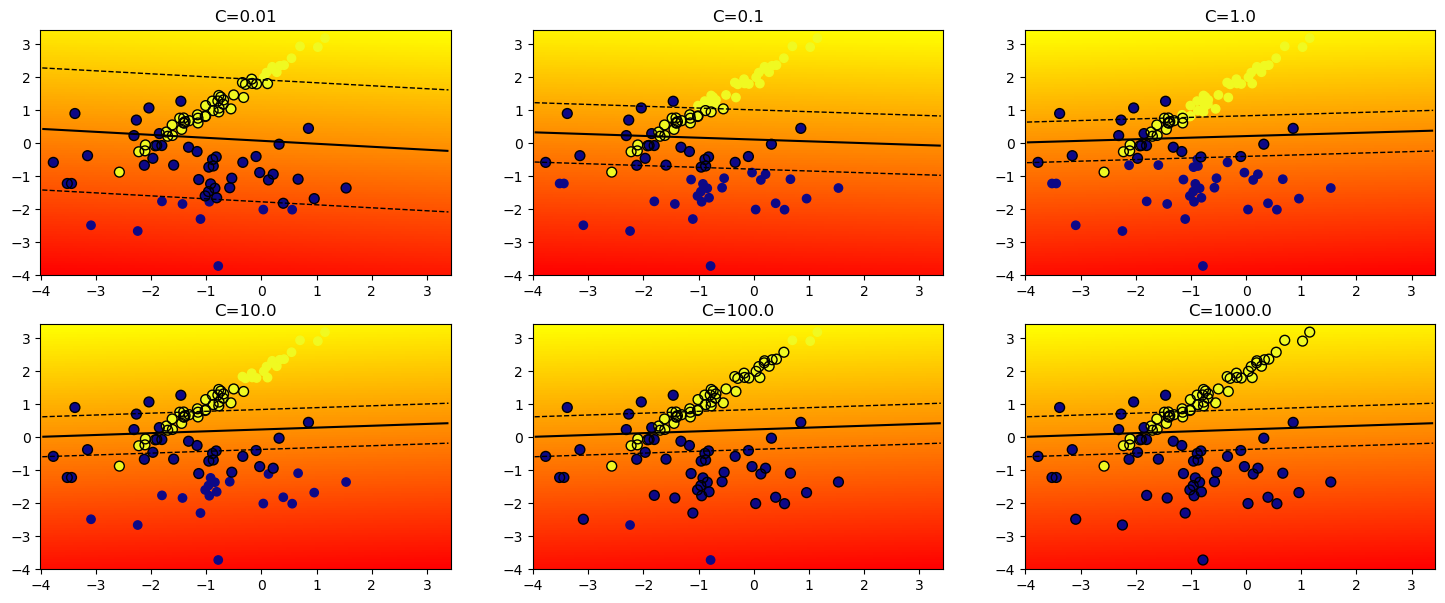

In [89]:
poly_ker_1 = lambda x1, x2: (np.dot(x1, x2.T) + 1) # 1 stepen
paint(X, y, poly_ker_1)

     pcost       dcost       gap    pres   dres
 0: -1.5584e+01 -2.0555e+00  7e+02  3e+01  2e-13
 1: -5.2352e-01 -2.0400e+00  1e+01  4e-01  2e-13
 2: -3.1424e-01 -1.5013e+00  2e+00  5e-02  3e-14
 3: -2.6883e-01 -1.0109e+00  1e+00  1e-02  8e-15
 4: -3.0158e-01 -4.0772e-01  1e-01  1e-03  3e-15
 5: -3.3473e-01 -3.6051e-01  3e-02  2e-04  2e-15
 6: -3.4432e-01 -3.4973e-01  6e-03  4e-05  3e-15
 7: -3.4483e-01 -3.4945e-01  5e-03  3e-05  3e-15
 8: -3.4700e-01 -3.4737e-01  4e-04  2e-17  3e-15
 9: -3.4716e-01 -3.4717e-01  7e-06  2e-17  3e-15
10: -3.4716e-01 -3.4716e-01  7e-08  2e-17  3e-15
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -1.6966e+01 -1.9973e+01  7e+02  3e+01  2e-13
 1: -2.8426e+00 -1.8521e+01  4e+01  9e-01  2e-13
 2: -1.9996e+00 -9.5647e+00  1e+01  2e-01  4e-14
 3: -2.0200e+00 -5.3150e+00  4e+00  6e-02  5e-14
 4: -2.0702e+00 -3.9608e+00  2e+00  2e-02  5e-14
 5: -2.2090e+00 -2.6846e+00  5e-01  5e-03  3e-14
 6: -2.2809e+00 -2.3731e+00  1e-01  5e-04  3e-1

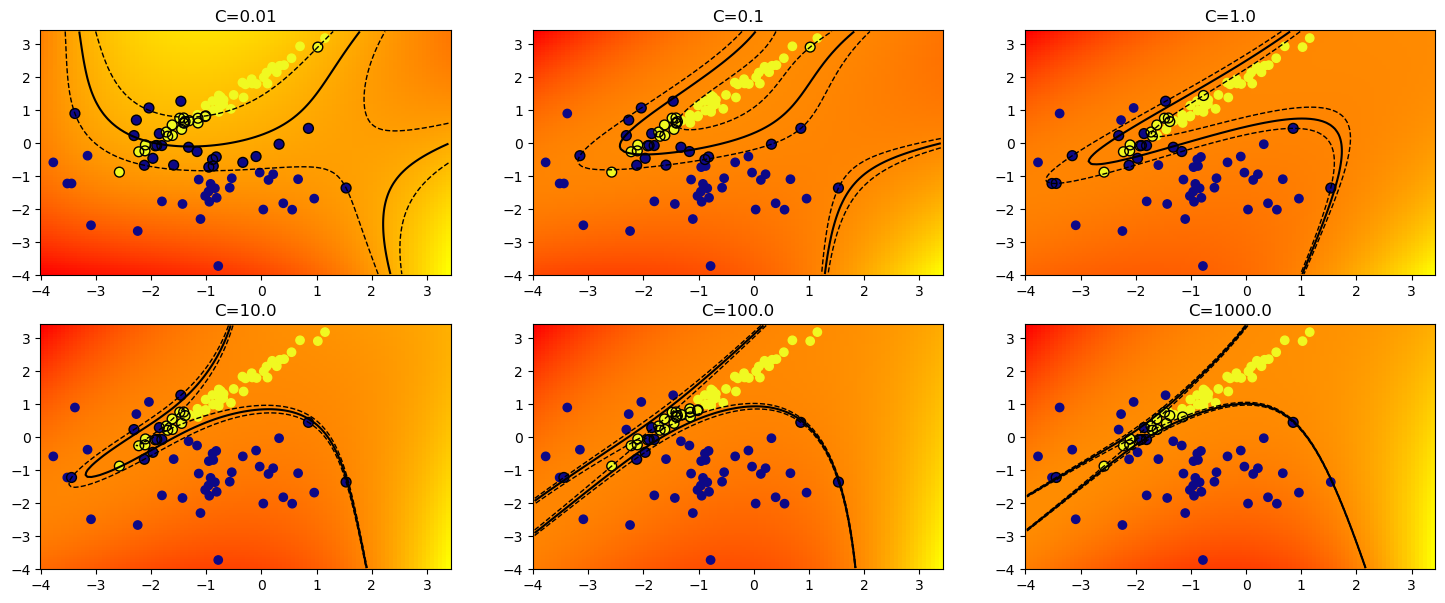

In [90]:
poly_ker_3 = lambda x1, x2: (np.dot(x1, x2.T) + 1)**3 # 3 stepen
paint(X, y, poly_ker_3)

     pcost       dcost       gap    pres   dres
 0: -9.0788e+00 -1.9829e+00  7e+02  3e+01  2e-10
 1: -2.6041e-01 -1.9657e+00  1e+01  3e-01  3e-10
 2: -1.5725e-01 -1.2400e+00  2e+00  4e-02  3e-11
 3: -1.4114e-01 -6.4646e-01  7e-01  1e-02  1e-11
 4: -1.3103e-01 -4.5947e-01  5e-01  7e-03  7e-12
 5: -1.2332e-01 -4.1362e-01  4e-01  6e-03  4e-12
 6: -1.1234e-01 -2.5643e-01  2e-01  3e-03  4e-12
 7: -1.0138e-01 -1.5034e-01  7e-02  6e-04  1e-12
 8: -1.0156e-01 -1.2132e-01  3e-02  2e-04  1e-12
 9: -1.0200e-01 -1.1265e-01  1e-02  8e-05  6e-13
10: -1.0272e-01 -1.0706e-01  5e-03  3e-05  2e-12
11: -1.0297e-01 -1.0532e-01  2e-03  2e-06  1e-12
12: -1.0367e-01 -1.0381e-01  1e-04  9e-08  2e-12
13: -1.0373e-01 -1.0374e-01  6e-06  3e-09  2e-12
14: -1.0373e-01 -1.0373e-01  5e-07  3e-10  2e-12
15: -1.0373e-01 -1.0373e-01  6e-09  3e-12  1e-12
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -9.8861e+00 -1.9640e+01  7e+02  3e+01  3e-10
 1: -1.6118e+00 -1.8031e+01  4e+01  9e-01  3e-1

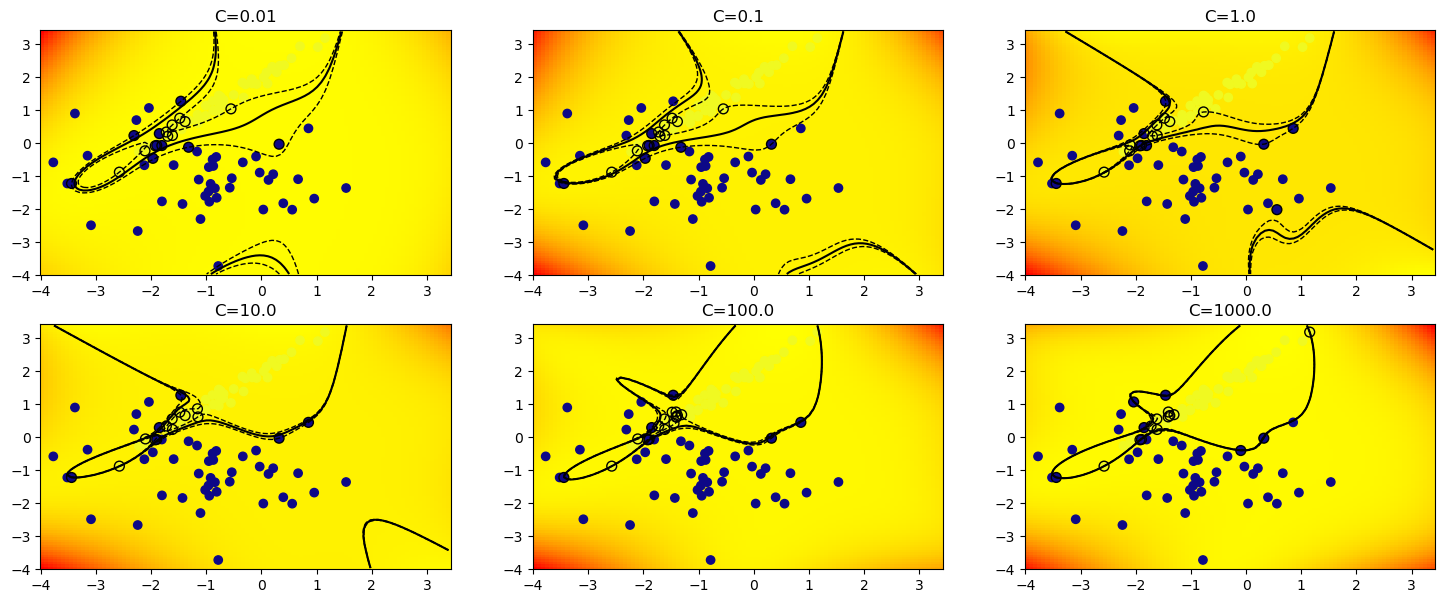

In [91]:
poly_ker_6 = lambda x1, x2: (np.dot(x1, x2.T) + 1) **6 # 6 stepen
paint(X, y, poly_ker_6)

Поведение SVM с полиномиальным ядром существенно зависит от двух основных параметров: параметра регуляризации \( C \) и степени полиномиального ядра \( p \). Эти параметры влияют на гибкость модели и на то, насколько она может подстраиваться под данные. Рассмотрим их влияние:

### 1. Параметр \( C \) — Регуляризация

- Низкое значение \( C \):
    - Модель будет сильно регуляризироваться, что приведет к более мягкому разделению классов. Это может быть полезно для избегания переобучения (overfitting).
    - Поддерживающие векторы могут быть выбраны дальше от границы раздела, что делает разделяющую гиперплоскость более широкой.
    - Модель будет менее чувствительна к ошибкам на обучающей выборке, что может привести к недообучению (underfitting).

- Высокое значение \( C \):
    - Модель будет стремиться к более точному разделению классов, жёстче подгоняя данные.
    - Поддерживающие векторы будут расположены ближе к границе раздела.
    - Модель станет менее терпимой к ошибкам, что может привести к переобучению, особенно если данные зашумлены.

Таким образом, выбор \( C \) регулирует баланс между переобучением и недообучением:
- Низкий \( C \): слабая подгонка, широкие границы.
- Высокий \( C \): сильная подгонка, узкие границы.

### 2. Степень полиномиального ядра \( p \)

- Низкая степень \( p = 1 \):
    - Полиномиальное ядро превращается в линейное ядро. В этом случае разделяющая гиперплоскость будет линейной.
    - SVM может не справляться с разделением сложных данных, если они не линейно разделимы.
  
- Увеличение степени \( p \):
    - С увеличением степени полинома гиперплоскость становится более гибкой и может создавать более сложные разделяющие поверхности.
    - Высокая степень полинома позволяет модели лучше подгоняться под данные, даже если они нелинейно разделимы.
    - Однако чрезмерно высокая степень может привести к переобучению, так как модель может слишком точно "выучить" сложные детали обучающих данных, включая шумы.
  
Таким образом, степень полинома влияет на сложность разделяющей поверхности:
- \( p = 1 \): линейное разделение.
- \( p = 2, 3, 4 \): квадратичное, кубическое и более сложное разделение.
- \( p \) слишком высокое: может возникнуть переобучение.

### Взаимодействие \( C \) и \( p \)

- Низкое \( C \) и высокое \( p \): Модель сгладит влияние более сложной разделяющей поверхности, что может уменьшить вероятность переобучения.
- Высокое \( C \) и высокое \( p \): Модель будет слишком сильно подстраиваться под обучающие данные, что часто приводит к переобучению.
- Оптимальные значения \( C \) и \( p \) нужно подбирать в зависимости от данных. Обычно используют перекрестную проверку (cross-validation) для поиска оптимальных параметров.

## Очень бы хотелось сделать задание 4, нооооооооооо 

IndexError: invalid index to scalar variable.

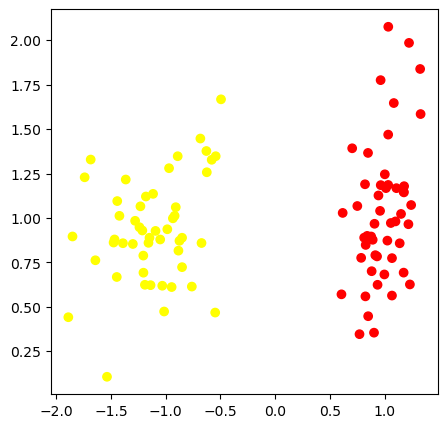

In [189]:
from sklearn.neighbors import KNeighborsClassifier

plt.figure(figsize=(5, 5))
plt.scatter(X[:, -0], X[:, 1], c=y, cmap='autumn')

xvals = np.linspace(-2, 2, 200)
yvals = np.linspace(-2, 2, 200)
xx, yy = np.meshgrid(xvals, yvals)

zz = np.reshape(predict_proba(np.c_[xx.ravel(), yy.ravel()])[:,1], xx.shape)

# Цветной фон, соответствующий значению решающего правила
plt.pcolormesh(xx, yy, zz, cmap='autumn', zorder=0)

# Линия уровня, соответствующая значению 0.5
plt.contour(xx, yy, zz, levels=(0.0,), colors='k', linewidths=1.5, zorder=1)

plt.xlim([-2, 2])
plt.ylim([-2, 2])
_ = title('KNN Decision Rule')